In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib as mpl, matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from functools import partial

<br>**Get the data to cluster**

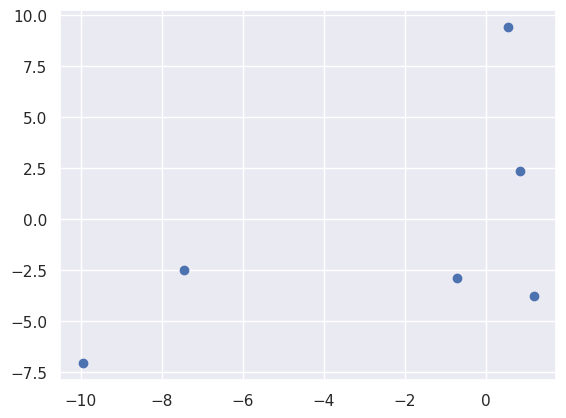

In [237]:
centers = torch.rand(6, 2)*20 - 10
plt.scatter(centers[:, 0], centers[:, 1])

In [216]:
n_samples = 1000

In [238]:
def sample(m): return MultivariateNormal(m, torch.tensor([[2.6, 0], [0, 2.6]]).float()).sample((n_samples, ))

In [239]:
points = torch.cat([sample(m) for m in centers], dim=0)

In [240]:
points.shape

torch.Size([6000, 2])

In [241]:
def plot_points(points, markers=None, ax=None):
    if ax == None: _, ax = plt.subplots()
    ax.scatter(points[:, 0], points[:, 1], s=3, c=markers)

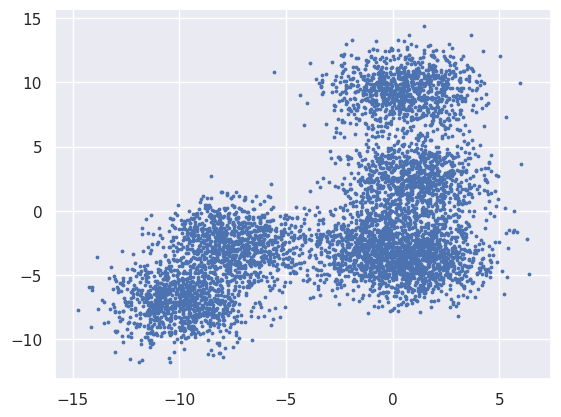

In [242]:
plot_points(points)

In [243]:
def plot_func(f, l=0, r=20):
    x = torch.linspace(0, 20, 500)
    plt.plot(x, f(x))

<br> **Make the algo**

In [299]:
eps = 0.7
min_cnt = 30

####  CLuster into {core, border, noise groups}

In [300]:
def get_matrix(points):
    return ((points[:, None, :] - points)**2).sum(dim=2) < eps**2

def get_markers(points):
    matrix = get_matrix(points)
    
    markers = torch.zeros(points.shape[0], dtype=torch.int32)  # 0-noise, 1-border, 2-core
    markers[matrix.sum(dim=1) >= min_cnt+1] = 2
    markers[((matrix.sum(dim=1) >= 2).int() * (matrix.sum(dim=1) < min_cnt+1).int()).bool()] = 1
    markers[matrix.sum(dim=1) == 1] = 0
    return matrix, markers

In [301]:
matrix, markers = get_markers(points)

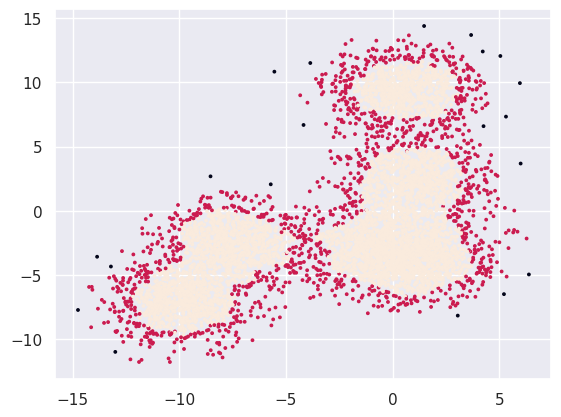

In [302]:
plot_points(points, markers)

#### Find each cluster and asign color

In [303]:
# Firstly, color cores
core_idxs = torch.where(markers == 2)[0]; core_idxs

tensor([   0,    1,    2,  ..., 5997, 5998, 5999])

In [304]:
# Should be bfs instead
def dfs(core_idx, color=1):
    clusters[core_idx] = color
    for next_core_idx in torch.where(matrix[core_idx])[0]:
        if (next_core_idx in core_idxs) and (clusters[next_core_idx] == 0):
            dfs(next_core_idx, color)

In [305]:
clusters = torch.zeros(points.shape[0], dtype=torch.int32)

cluster_color = 0
for core_idx in core_idxs:
    if clusters[core_idx] == 0:
        cluster_color += 1
        dfs(core_idx, cluster_color)

In [306]:
clusters.unique()

tensor([0, 1, 2, 3], dtype=torch.int32)

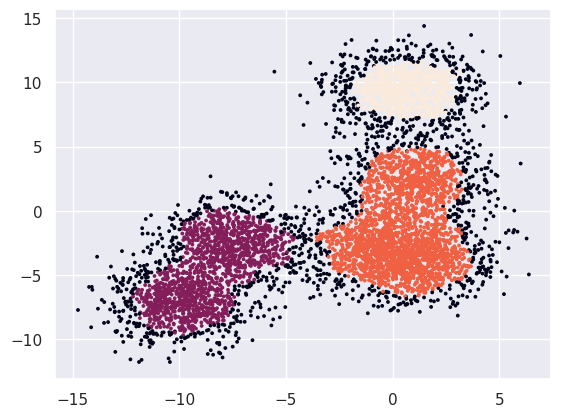

In [307]:
plot_points(points, markers=clusters)

In [308]:
# Now color borders
border_idxs = torch.where(markers == 1)[0]; len(border_idxs)

1309

In [309]:
# border color is the most common non-zero color in it's area
for border_idx in border_idxs:
    reachable_points = clusters[torch.where(matrix[border_idx])[0]]
    reachable_points = reachable_points[reachable_points != 0]
    if len(reachable_points) > 0:
        clusters[border_idx] = torch.mode(reachable_points).values.item()

<Axes: ylabel='Count'>

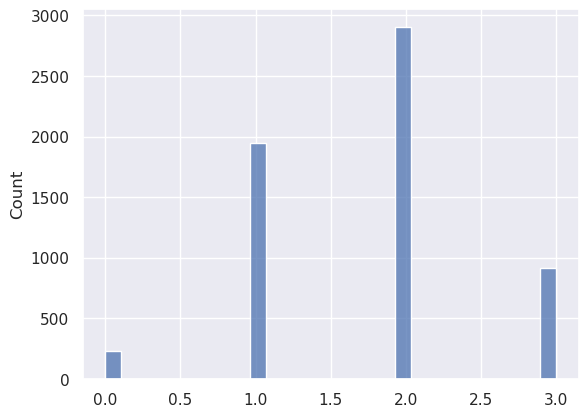

In [310]:
sns.histplot(clusters)

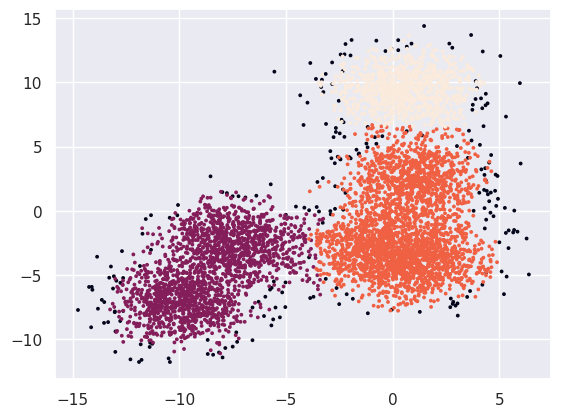

In [311]:
plot_points(points, clusters)

<br>**sklearn DBSCAN**

In [312]:
from sklearn.cluster import DBSCAN

In [315]:
dbscan = DBSCAN(eps=0.7, min_samples=30)
dbscan.fit(points.detach().numpy())

DBSCAN(eps=0.7, min_samples=30)

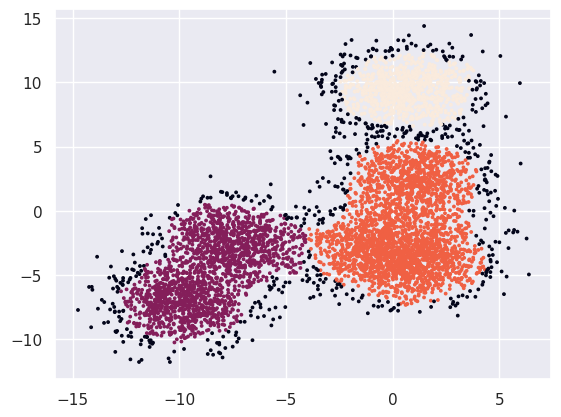

In [316]:
plot_points(points, dbscan.labels_)

<br>**Get the video**

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def one_update(d):
    global points_copy
    if d: points_copy = get_weighted_mean(points_copy, bw=2)
    ax.clear()
    plot_points(points_copy, centers+0.3, ax=ax)

In [ ]:
def meanshift(it=9):
    global points_copy
    #points_copy = points.clone()
    for i in range(it):
        points_copy = get_weighted_mean(points_copy, bw=2)

In [ ]:
points_copy = points.clone()
meanshift()
plot_points(points_copy, centers+0.3)

In [ ]:
points_copy = points.clone()
%timeit meanshift()

In [ ]:
points_copy = points.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, one_update, frames=9, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

<br><br> **GPU acceleration**

In [ ]:
bs = 5
points_b = points[bs:2*bs]; points_b.shape

In [ ]:
def dist(points_b, points):
    # points_b: (bs, 2), points: (n, 2)
    return torch.sqrt(((points_b[:, None, :] - points)**2).sum(dim=2))
def weight_func(tens, bw=2):
    return torch.clip(1-tens/bw, min=0)

In [ ]:
dist(points_b, points)[:, :5]

In [ ]:
weight_func(dist(points_b, points))[:, :5]

In [ ]:
def get_weighted_mean(points_b, points, bw=2):
    weighted_dist = weight_func(dist(points_b, points), bw=bw)
    weighted_mean = (weighted_dist@points)/weighted_dist.sum(dim=1, keepdim=True)
    return weighted_mean

In [ ]:
get_weighted_mean(points_b, points)

In [ ]:
def meanshift(points, bs=400, it=9):
    X = points.clone()
    n = X.shape[0]
    for i in range(it):
        #for batch in range(0, X.shape[0], bs):
        #    X[batch:batch+bs] = get_weighted_mean(X[batch:batch+bs], X, bw=2.5)
        X = torch.cat([get_weighted_mean(X[batch:min(n, batch+bs)], X, bw=2.5) for batch in range(0, n, bs)], dim=0)
    return X

In [ ]:
X = meanshift(points, bs=1024, it=7)
plot_points(X, centers+0.3)